# Exercise: Train a CNN model using MNIST data

Convolutional Neural Networks (CNNs) are a powerful tool for image classification tasks. In this exercise, we will explore the process of training a CNN model using the MNIST dataset, a widely-used benchmark dataset for handwritten digit recognition. To accomplish this, we will use PyTorch.

In [1]:
# Install needed packages if not already installed

! pip install -q torch torchvision matplotlib

In [2]:
# Import packages for the entire notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
# Various helper functions

def imshow(img, size=3):
    """Display an image in the notebook"""
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()  # convert to numpy array
    plt.figure(figsize=(size, size))  # specific the figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")  # transpose the array
    plt.show()


## Load and preprocess the MNIST dataset

Use the torchvision library to load the MNIST dataset. Preprocess the dataset by applying any necessary transformations, such as normalization or resizing, to prepare the data for training.

In [4]:
# Load the MNIST dataset

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

# Set batch size
bs = 64

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=bs, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=bs, shuffle=False, num_workers=2
)

In [5]:
# Show the classes of the dataset
for class_name in trainset.classes:
    print(class_name)

0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine


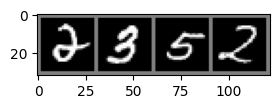

2 - two, 3 - three, 5 - five, 2 - two


In [6]:
# Show some examples with the labels

# Get some random training images
images, labels = next(iter(trainloader))

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(", ".join(trainset.classes[labels[j]] for j in range(min(4, bs))))

## Define the CNN model architecture

Create a CNN model architecture using PyTorch's nn.Module class. Define the layers, activation functions, and any other components required for the model.

In [7]:
# Define the CNN

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 6, 5
        )  # 1 input channel, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride 2
        self.conv2 = nn.Conv2d(
            6, 16, 5
        )  # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(
            16 * 4 * 4, 120
        )  # 16*4*4 input features, 120 output features
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10)  # 84 input features, 10 output features

    def forward(self, x):
        x = self.pool(
            F.relu(self.conv1(x))
        )  # Convolutional layer 1, followed by ReLU and pooling
        x = self.pool(
            F.relu(self.conv2(x))
        )  # Convolutional layer 2, followed by ReLU and pooling
        x = x.view(-1, 16 * 4 * 4)  # Reshape to 16*4*4 features
        x = F.relu(self.fc1(x))  # Fully connected layer 1, followed by ReLU
        x = F.relu(self.fc2(x))  # Fully connected layer 2, followed by ReLU
        x = self.fc3(x)  # Fully connected layer 3
        return x


my_cnn = MyCNN()

In [8]:
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_cnn.parameters(), lr=0.001, momentum=0.9)

## Train the CNN model

Use the prepared dataset and the defined model to train the CNN. This involves iterating over the dataset, passing the input images through the model, calculating the loss, and updating the model's parameters using backpropagation and gradient descent.

In [9]:
# Specify the device to train on

# We will use a GPU if available, otherwise we will use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

63.96588486140725

In [16]:
# Define a training loop
my_cnn.to(device)  # move the model to the device


for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):  # trainloader contains the training data
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move the data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()  # set the gradients to zero

        # forward + backward + optimize
        outputs = my_cnn(inputs)  # compute the output
        loss = criterion(outputs, labels)  # compute the loss
        loss.backward()  # compute the gradients
        optimizer.step()  # update the weights

        # print statistics
        running_loss += loss.item()
        if i % (200) == 199:  # print every 200 batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,   200] loss: 0.016
[1,   400] loss: 0.015
[1,   600] loss: 0.014
[1,   800] loss: 0.014
[2,   200] loss: 0.013
[2,   400] loss: 0.011
[2,   600] loss: 0.012
[2,   800] loss: 0.011


## Evaluate the trained model

After training, evaluate the performance of the trained CNN model on a separate test dataset. Calculate metrics such as accuracy, precision, and recall to assess the model's performance in classifying handwritten digits.

In [17]:
# Show the loss and accuracy on the test set

correct = 0
total = 0
loss = 0
with torch.no_grad():  # we don't need to compute the gradients here
    for data in testloader:  # testloader contains the test data
        images, labels = data

        # move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = my_cnn(images)  # compute the output
        _, predicted = torch.max(outputs.data, 1)  # get the predicted class

        total += labels.size(0)  # add the number of labels
        correct += (
            (predicted == labels).sum().item()
        )  # add the number of correct predictions

        loss += criterion(outputs, labels).item()  # add the loss

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))
print("Average loss: %.3f" % (loss / total))

Accuracy of the network on the test images: 96 %
Average loss: 0.002


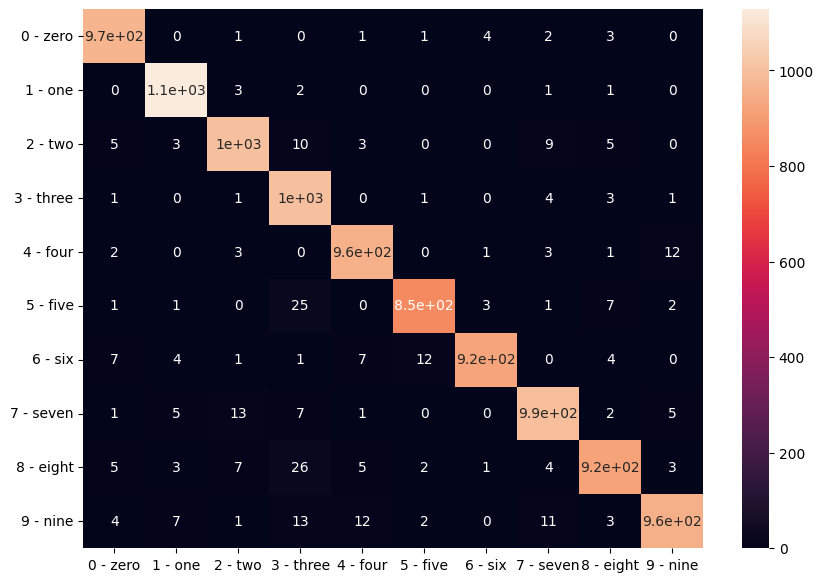

In [18]:
# Show the confusion matrix on the test dataset



y_true = []
y_pred = []
with torch.no_grad():  # we don't need to compute the gradients here
    for data in testloader:  # testloader contains the test data
        images, labels = data

        # move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = my_cnn(images)  # compute the output
        _, predicted = torch.max(outputs.data, 1)  # get the predicted class

        y_true += labels.tolist()
        y_pred += predicted.tolist()

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cm, index=[i for i in trainset.classes], columns=[i for i in trainset.classes]
)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)
plt.show()

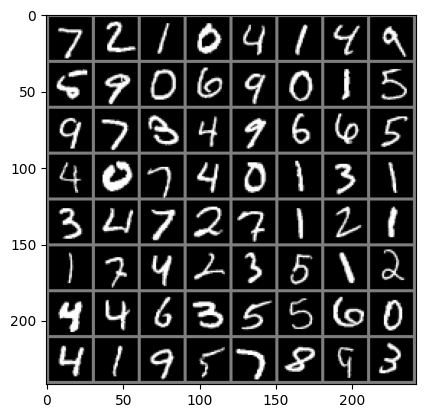

GroundTruth:  7 - seven, 2 - two, 1 - one, 0 - zero, 4 - four, 1 - one, 4 - four, 9 - nine, 5 - five, 9 - nine, 0 - zero, 6 - six, 9 - nine, 0 - zero, 1 - one, 5 - five, 9 - nine, 7 - seven, 3 - three, 4 - four, 9 - nine, 6 - six, 6 - six, 5 - five, 4 - four, 0 - zero, 7 - seven, 4 - four, 0 - zero, 1 - one, 3 - three, 1 - one, 3 - three, 4 - four, 7 - seven, 2 - two, 7 - seven, 1 - one, 2 - two, 1 - one, 1 - one, 7 - seven, 4 - four, 2 - two, 3 - three, 5 - five, 1 - one, 2 - two, 4 - four, 4 - four, 6 - six, 3 - three, 5 - five, 5 - five, 6 - six, 0 - zero, 4 - four, 1 - one, 9 - nine, 5 - five, 7 - seven, 8 - eight, 9 - nine, 3 - three
Predicted:  7 - seven, 2 - two, 1 - one, 0 - zero, 4 - four, 1 - one, 4 - four, 9 - nine, 5 - five, 9 - nine, 0 - zero, 6 - six, 9 - nine, 0 - zero, 1 - one, 5 - five, 9 - nine, 7 - seven, 3 - three, 4 - four, 9 - nine, 6 - six, 6 - six, 5 - five, 4 - four, 0 - zero, 7 - seven, 4 - four, 0 - zero, 1 - one, 3 - three, 1 - one, 3 - three, 4 - four, 7 - 

In [19]:
# Show 25 random images and their predicted labels



# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose the array
    plt.show()


# get some random test images
images, labels = next(iter(testloader))

# move the data to the device
images = images.to(device)
labels = labels.to(device)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(
    "GroundTruth: ", ", ".join("%5s" % trainset.classes[labels[j]] for j in range(bs))
)

# compute the outputs
outputs = my_cnn(images)

# get the predicted classes
_, predicted = torch.max(outputs, 1)

# print predicted labels
print(
    "Predicted: ", ", ".join("%5s" % trainset.classes[predicted[j]] for j in range(bs))
)

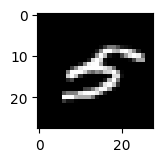

Predicted:  3 - three , Ground truth:  5 - five


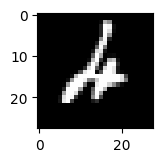

Predicted:  2 - two , Ground truth:  4 - four


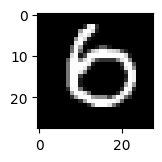

Predicted:  0 - zero , Ground truth:  6 - six


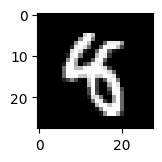

Predicted:  4 - four , Ground truth:  8 - eight


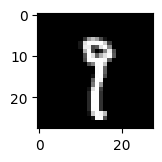

Predicted:  7 - seven , Ground truth:  9 - nine


In [22]:
# Show the first 10 misclassified images


misclassified_num = 0

# iterate through all the test images one-by-one
single_testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=False, num_workers=1
)
for images, labels in single_testloader:
    # move the data to the device
    images = images.to(device)
    labels = labels.to(device)

    # compute the outputs
    outputs = my_cnn(images)

    # get the predicted classes
    _, predicted = torch.max(outputs, 1)

    # get the indices of the misclassified images
    misclassified = (predicted != labels).nonzero()[:, 0]

    # if there are no misclassified images, continue
    if len(misclassified) > 0:
        misclassified_num += 1

        # show the misclassified images
        imshow(torchvision.utils.make_grid(images[misclassified]), size=1.5)

        index = misclassified.item()
        print('Predicted: ', trainset.classes[predicted[index]], ', Ground truth: ', trainset.classes[labels[index]])

    if misclassified_num >= 5:
        break